In [1]:
# %load_ext pep8magic
%matplotlib inline
# standard
import csv
import codecs
import glob
import json
import os
import re
import time
# 3rd-party
import matplotlib.pyplot as plt
import pandas as pd
import pytablewriter
import requests_oauthlib
from scipy import stats
# self-made
from conf import *

In [2]:
"""
read raw csv
file is obtained by Twitter Media Downloader
https://memo.furyutei.work/entry/20160723/1469282864
"""
# read the latest file in the csv folder
dir = sorted(glob.glob('./CSV/*/'))[-1]
file = glob.glob(dir+'*dryrun.csv')[0]
c_d = ""
with codecs.open(file, "r", "utf-8", "ignore") as f:
    c_d = pd.read_csv(f,
                      parse_dates=['Tweet date'],
                      # skiprows=[0, 1, 2, 3]
                      skiprows=[0, 1, 2, 3, 4])
c_d

,Tweet date,Action date,Display name,Username,Tweet URL,Media type,Media URL,Saved filename,Remarks,Tweet content,Replies,Retweets,Likes
0,2020-08-23 15:19:41,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12974...,No media,NaN,NaN,NaN,うんこうんこうんこ https://twitter.com/amanoese/status/...,NaN,1.0,3.0
1,2020-08-23 15:19:00,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12974...,No media,NaN,NaN,NaN,うんここ https://twitter.com/amanoese/status/12974...,NaN,1.0,1.0
2,2020-08-23 14:48:40,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12974...,No media,NaN,NaN,NaN,ツタージャはかわいい https://twitter.com/kazu220_ps/stat...,NaN,NaN,1.0
3,2020-08-23 14:45:55,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12974...,Image,https://pbs.twimg.com/media/EgFTQrzVAAUhLcJ?fo...,minyoruminyon-1297409715329101826-20200823_144...,NaN,https://twitter.com/kazu220_ps/status/12974096...,NaN,NaN,1.0
4,2020-08-23 14:44:08,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12974...,Image,https://pbs.twimg.com/media/EgFS2pMU4AAZ62e?fo...,minyoruminyon-1297409267675217922-20200823_144...,NaN,https://twitter.com/kazu220_ps/status/12974092...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55487,2017-06-28 09:20:26,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87985...,No media,NaN,NaN,NaN,echo -e #\x30B7ェル芸\ncat $0 https://twitter.com...,NaN,NaN,1.0
55488,2017-06-28 09:15:09,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87985...,No media,NaN,NaN,NaN,/duomGa0j5k\n https://twitter.com/4snt1/status...,NaN,NaN,NaN
55489,2017-06-27 23:37:24,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87971...,No media,NaN,NaN,NaN,ok\n https://twitter.com/theoldmoon0602/status...,NaN,NaN,NaN
55490,2017-06-27 23:30:49,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/87970...,No media,NaN,NaN,NaN,ほげ\n https://twitter.com/theoldmoon0602/status...,NaN,NaN,NaN


In [3]:
# fetch tweeted user from tweet link URL by API
"""
statuses/show/:id ツイートid1つから取得
900tweet/15m
(wait: /1req)
処理簡単

statuses/lookup ツイートid100つから取得
30000tweet/15m
処理複雑(そうでもない)
"""


def getUser(url, twitter):
    params = {
        'id': re.search(r'^(\d+)', url[::-1]).groups()[0][::-1],
        'trim_user': 'false',
        'include_my_retweet': 'false',
        'include_entities': 'true',
    }
    while True:
        req = twitter.get('https://api.twitter.com/1.1/statuses/show.json',
                          params=params)
        time.sleep(1)
        if req.status_code == 200:
            j = json.loads(req.text)
            try:
                return j['quoted_status']['user']['screen_name']
            except KeyError:
                """
                estimate from the URL in tweet
                when the quoted tweet has been deleted (Reliability: low)
                """
                urls = [u['expanded_url'] for u in j['entities']['urls']]
                cand = [re.search(r'https://twitter.com/([^/]+)/status/\d+',
                                  u) for u in urls]
                cand = [t.groups(1)[0] for t in cand if t]
                if cand:
                    return cand[0]
                else:
                    return 'minyoruminyon'
        else:
            continue


In [4]:
# make formatted.csv
newcsv = {'Date': c_d['Tweet date'],
          'URL': c_d['Tweet URL'],
          'User': [],
          'R+L': c_d['Retweets'].fillna(0) + c_d['Likes'].fillna(0),
          'Retweets': c_d['Retweets'],
          'Likes': c_d['Likes'],
          'm': c_d['Tweet content']
         }

# estimate one specific user posted a tweet
# which was RT'd by @minyoruminyon
twitter = requests_oauthlib.OAuth1Session(CK, CS, t_AT, AS)
i, cnt, lineno = 0, 0, len(c_d)
for l in [[k, v] for k, v in zip(newcsv['URL'], newcsv['m'])]:
    i += 1
    user = re.findall(
        r'https://twitter.com/([a-zA-Z0-9_]+)/status/[0-9]+',
        l[1])
    user = list(set(user)-set(['minyoruminyon']))
    print("%05d/%d:%s..." % (i, lineno, str(user)[0:35]),
          " " * 50, end="\r")
    if not user:
        user = 'minyoruminyon'
    else:
        if user == ['minyoruminyon']:
            user = 'minyoruminyon'
        elif len(user) == 1:
            user = user[0]
        else:
            user = getUser(l[0], twitter)
            cnt += 1
            time.sleep(1)
    newcsv['User'].append(user)
print("Process Ended.(about: %ds, line: %d)" %(cnt + 1, lineno))
newcsv.pop('m')
pd.DataFrame(newcsv).fillna(0).to_csv(dir+'formatted.csv', index=None)
pd.read_csv(dir + 'formatted.csv')

00732/55492:['hisa0211']... 

01482/55492:['hchbaw']...

02981/55492:['eban']...                                                   

Process Ended.(about: 27s, line: 55492)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

,Date,URL,User,R+L,Retweets,Likes
0,2020-08-23 15:19:41,https://twitter.com/minyoruminyon/status/12974...,amanoese,4.0,1.0,3.0
1,2020-08-23 15:19:00,https://twitter.com/minyoruminyon/status/12974...,amanoese,2.0,1.0,1.0
2,2020-08-23 14:48:40,https://twitter.com/minyoruminyon/status/12974...,kazu220_ps,1.0,0.0,1.0
3,2020-08-23 14:45:55,https://twitter.com/minyoruminyon/status/12974...,kazu220_ps,1.0,0.0,1.0
4,2020-08-23 14:44:08,https://twitter.com/minyoruminyon/status/12974...,kazu220_ps,0.0,0.0,0.0
...,...,...,...,...,...,...
55487,2017-06-28 09:20:26,https://twitter.com/minyoruminyon/status/87985...,4snt1,1.0,0.0,1.0
55488,2017-06-28 09:15:09,https://twitter.com/minyoruminyon/status/87985...,4snt1,0.0,0.0,0.0
55489,2017-06-27 23:37:24,https://twitter.com/minyoruminyon/status/87971...,theoldmoon0602,0.0,0.0,0.0
55490,2017-06-27 23:30:49,https://twitter.com/minyoruminyon/status/87970...,theoldmoon0602,0.0,0.0,0.0


In [5]:
# read formatted.csv
f_d = pd.read_csv(dir+'formatted.csv')
# make user.csv
userdata = []
c = 1
tmp = None
for k, v in f_d['User'].value_counts().items():
    if tmp != v:
        c += 1
    if not tmp:
        tmp = v
    tmp = v
    userdata.append([c-1, k, v])
with open(dir+'user.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['Rank', 'User', 'Count'])
    w.writerows(userdata)
pd.read_csv(dir+'user.csv')

,Rank,User,Count
0,1,jiro_saburomaru,5961
1,2,ryuichiueda,4531
2,3,blacknon_,3137
3,4,yami_buta,3032
4,5,qwertanus,2465
...,...,...,...
1650,149,Aya_Furusawa,1
1651,149,MinatooKy,1
1652,149,thiqxis,1
1653,149,favoPushMan,1


In [6]:
# make buzz.csv
buzz = f_d.sort_values('R+L', ascending=False)
buzz.to_csv(dir+'buzz.csv', index=None)
# reindex
buzz = pd.read_csv(dir+'buzz.csv')
buzz.index = buzz.index + 1
buzz.to_csv(dir+'buzz.csv')
buzz[0:1000].to_csv(dir+'buzz_1000.csv')
pd.read_csv(dir+'buzz_1000.csv')

,Unnamed: 0,Date,URL,User,R+L,Retweets,Likes
0,1,2020-01-28 09:02:17,https://twitter.com/minyoruminyon/status/12219...,yami_buta,4268.0,1404.0,2864.0
1,2,2019-05-21 22:08:09,https://twitter.com/minyoruminyon/status/11308...,ryuichiueda,2406.0,984.0,1422.0
2,3,2020-04-02 22:32:26,https://twitter.com/minyoruminyon/status/12457...,yami_buta,1225.0,462.0,763.0
3,4,2020-08-14 10:46:22,https://twitter.com/minyoruminyon/status/12940...,Sheeeeepla,1147.0,354.0,793.0
4,5,2019-06-30 23:15:50,https://twitter.com/minyoruminyon/status/11453...,yami_buta,937.0,302.0,635.0
...,...,...,...,...,...,...,...
995,996,2019-08-17 11:33:49,https://twitter.com/minyoruminyon/status/11625...,yukito_2828,19.0,5.0,14.0
996,997,2019-05-27 12:08:32,https://twitter.com/minyoruminyon/status/11328...,__nitmcmasa__,19.0,10.0,9.0
997,998,2017-09-30 12:15:42,https://twitter.com/minyoruminyon/status/91396...,eban,19.0,10.0,9.0
998,999,2019-11-20 18:40:24,https://twitter.com/minyoruminyon/status/11970...,yami_buta,19.0,7.0,12.0


In [7]:
# by month
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
bymonth = []
for y in t['Date'].dt.year.unique()[::-1]:
    for m in range(1, 13):
        bymonth.append(["%d/%d" % (y, m),
                       len(t[(t['Date'].dt.year == y) &
                             (t['Date'].dt.month == m)])])
with open(dir+'month.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in bymonth]
pd.read_csv(dir+'month.csv')

,2017/1,0
0,2017/2,0
1,2017/3,0
2,2017/4,0
3,2017/5,0
4,2017/6,177
5,2017/7,578
6,2017/8,327
7,2017/9,284
8,2017/10,304
9,2017/11,178


In [8]:
# by hour
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
byhour = []
for h in range(0, 24):
    byhour.append(["%02d" % h,
                  len(t[(t['Date'].dt.hour == h)])])
with open(dir+'hour.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in byhour]
pd.read_csv(dir+'hour.csv')

,00,3121
0,1,1925
1,2,1107
2,3,684
3,4,518
4,5,436
5,6,728
6,7,1264
7,8,1896
8,9,2204
9,10,2559


In [9]:
# extract some user's one
try:
    os.makedirs(dir+'/user/')
except FileExistsError:
    pass


def extractUser(target):
    n = dir+'/user/%s.csv' % target
    a = pd.read_csv(dir + 'formatted.csv')
    a[(a['User'] == target)].to_csv(n, index=False)
    pd.read_csv(n).to_csv(n)
    return pd.read_csv(n)

u = pd.read_csv(dir + 'user.csv')
for t in u[(u['Count'] > 9)]['User']:
    print(t, '            ', end="\r")
    extractUser(t)
print('========END========')

========END========         


In [10]:
u = pd.read_csv(dir+'user.csv')
print(len(u),
      len(u[(u['Count'] > 9)]))

1655 507


In [11]:
# make user.md
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(
    u.replace({'User': r'([0-9_a-zA-Z]+)'},
              {'User': r'[\1](https://twitter.com/\1)'}, regex=True))
writer.dump(dir+"user.md")
writer.write_table()

|Rank|                         User                         |Count|
|---:|------------------------------------------------------|----:|
|   1|[jiro_saburomaru](https://twitter.com/jiro_saburomaru)| 5961|
|   2|[ryuichiueda](https://twitter.com/ryuichiueda)        | 4531|
|   3|[blacknon_](https://twitter.com/blacknon_)            | 3137|
|   4|[yami_buta](https://twitter.com/yami_buta)            | 3032|
|   5|[qwertanus](https://twitter.com/qwertanus)            | 2465|
|   6|[egpl0](https://twitter.com/egpl0)                    | 2093|
|   7|[grethlen](https://twitter.com/grethlen)              | 1172|
|   8|[QiToYtkg](https://twitter.com/QiToYtkg)              | 1171|
|   9|[eban](https://twitter.com/eban)                      |  870|
|  10|[ytkmns](https://twitter.com/ytkmns)                  |  856|
|  11|[shishimy](https://twitter.com/shishimy)              |  693|
|  12|[kazuki_199778](https://twitter.com/kazuki_199778)    |  576|
|  13|[CareleSmith9](https://twitter.com/CareleS

| 149|[FU_RAT_O](https://twitter.com/FU_RAT_O)              |    1|
| 149|[okudaira3rd](https://twitter.com/okudaira3rd)        |    1|
| 149|[__ramen](https://twitter.com/__ramen)                |    1|
| 149|[suzushiroz](https://twitter.com/suzushiroz)          |    1|
| 149|[EOYlcjIU0gtziJ8](https://twitter.com/EOYlcjIU0gtziJ8)|    1|
| 149|[yuki013_](https://twitter.com/yuki013_)              |    1|
| 149|[Niratama](https://twitter.com/Niratama)              |    1|
| 149|[Rrori6](https://twitter.com/Rrori6)                  |    1|
| 149|[rhorin_uec](https://twitter.com/rhorin_uec)          |    1|
| 149|[dolyplpl](https://twitter.com/dolyplpl)              |    1|
| 149|[_serinuntius](https://twitter.com/_serinuntius)      |    1|
| 149|[shin_okamatsu](https://twitter.com/shin_okamatsu)    |    1|
| 149|[HlBIKI](https://twitter.com/HlBIKI)                  |    1|
| 149|[shimesaba_C9](https://twitter.com/shimesaba_C9)      |    1|
| 149|[zawaru3](https://twitter.com/zawaru3)    

In [12]:
# make buzz.md
writer = pytablewriter.MarkdownTableWriter()
b = pd.read_csv(dir+'buzz.csv').replace(
            {'User':r'([0-9_a-zA-Z]+)'}, 
            {'User':r'[\1](https://twitter.com/\1)'},regex=True
    ).replace(
            {'URL':r'(^.*$)'}, 
            {'URL':r'[\1](\1)'},regex=True
    )
writer.from_dataframe(b)
writer.dump(dir+"buzz.md")
writer.from_dataframe(b[0:1000])
writer.dump(dir+"buzz_1000.md")
writer.from_dataframe(b[0:500])
writer.dump(dir+"buzz_500.md")
writer.from_dataframe(b[0:100])
writer.dump(dir+"buzz_100.md")
writer.write_table()

|Unnamed: 0|       Date        |                                                            URL                                                             |                         User                         |R+L |Retweets|Likes|
|---------:|-------------------|----------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------|---:|-------:|----:|
|         1|2020-01-28 09:02:17|[https://twitter.com/minyoruminyon/status/1221946561506078720](https://twitter.com/minyoruminyon/status/1221946561506078720)|[yami_buta](https://twitter.com/yami_buta)            |4268|    1404| 2864|
|         2|2019-05-21 22:08:09|[https://twitter.com/minyoruminyon/status/1130822587242561536](https://twitter.com/minyoruminyon/status/1130822587242561536)|[ryuichiueda](https://twitter.com/ryuichiueda)        |2406|     984| 1422|
|         3|2020-04-02 22:32:26|[https://twitter.com/minyoruminyon/s

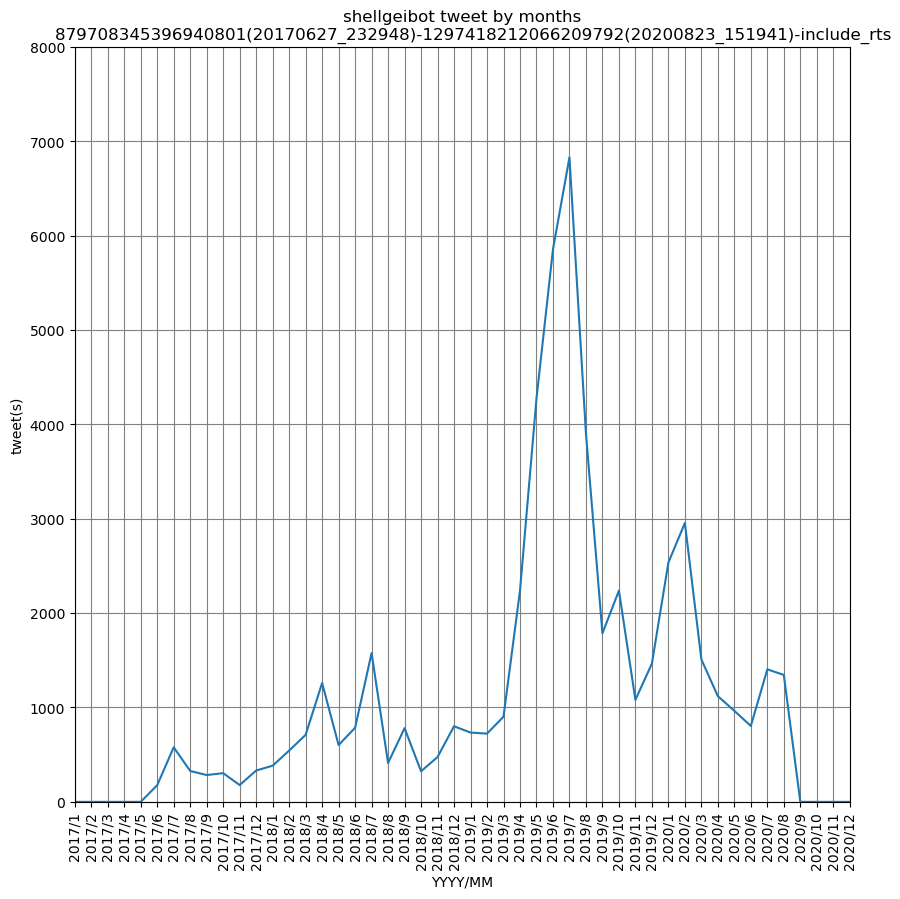

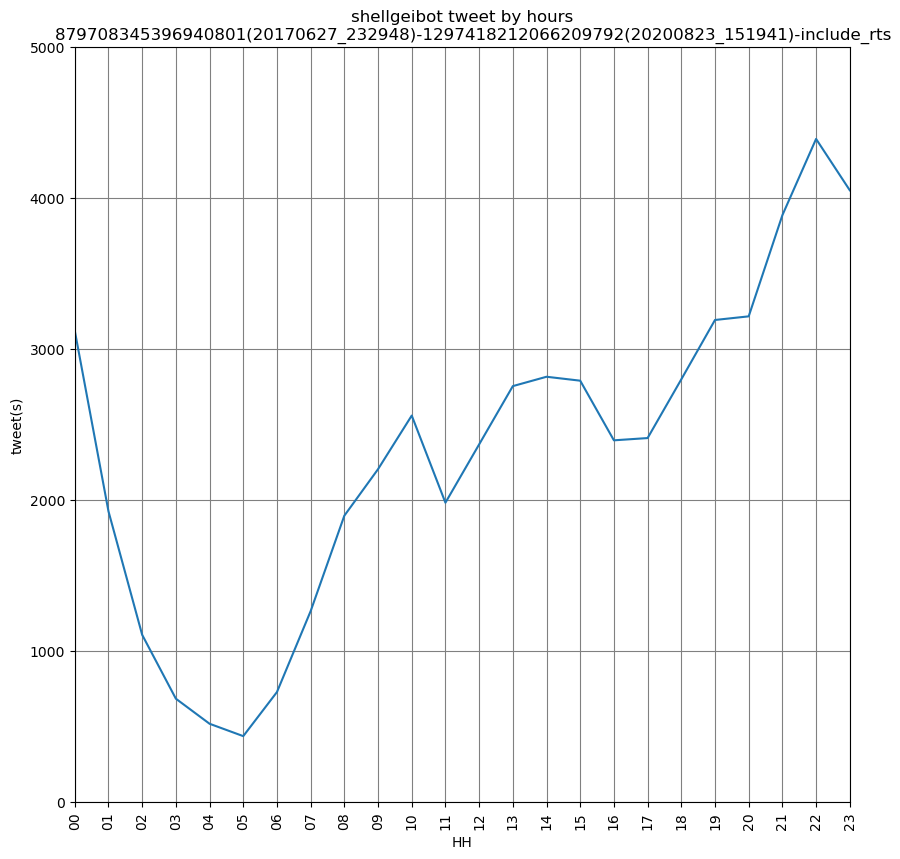

In [13]:
# make graphs
def showgraph(name, title, xlabel, ylim, dir):
    f = [i.split(',') for i in open(name).readlines()]
    x, y = [], []
    for i in f:
        x.append(i[0])
        y.append(int(i[1]))

    plt.figure(figsize=(10, 10), dpi=100)
    plt.xlim(0, len(x)-1)
    plt.ylim(0, ylim)
    plt.grid(color='gray')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('tweet(s)')
    plt.plot(x, y)
    plt.xticks(rotation=90)
    plt.savefig(dir + title + '.png')
showgraph(
    dir+"month.csv",
    """shellgeibot tweet by months
    %s""" % (file[49:][:-11]),
    "YYYY/MM",
    8000,
    dir
)
showgraph(
    dir+"hour.csv",
    """shellgeibot tweet by hours
    %s""" % (file[49:][:-11]),
    "HH",
    5000,
    dir
)